# Chapter 6 モデルのチューニング

## 6.1 パラメータチューニング

### 6.1.1 ハイパーパラメータの探索方法

- 手動
- グリッドサーチ
- ランダムサーチ
- ベイズ最適化

----

- 手動
    - 手動で頑張る。


- グリッドサーチ
    - ハイパーパラメータの候補を決めて網羅的に探索する手法。計算コストが高い
    - scikit-learnのmodel_selectionモジュールのGridSearchCVという実装がある


- ランダムサーチ
    - 候補点を適当に見繕ってランダムに組み合わせる。設定した計算回数まで行ったら終わり
    - RandomizedSearchCVという実装がある。
    
    
- ベイズ最適化
    - 以前に計算したハイパーパラメータの履歴に基づいて次にt探索すべきハイパーパラメータをベイズ確率に基づいて選択する手法。
    - ライブラリ hyperopt, gpyoptm spearmint, scikit-optimize, optunaが挙げられる
    - トースターのおすすめはoptuna

In [1]:
# グリッドサーチ、 ランダムサーチのコード
import numpy as np

param1_list = [3, 5, 7, 9]
param2_list = [1, 2, 3, 4, 5]

# grid serach
grid_search_params = []
for p1 in param1_list:
    for p2 in param2_list:
        grid_search_params.append((p1, p2))

#こっちの方が速い(grid search)
grid_search_params2 = [(p1, p2) for p1 in param1_list for p2 in param2_list]

#ランダムサーチ
random_search_param = []
trials = 15
for i in range(trials):
    p1 = np.random.choice(param1_list)
    p2 = np.random.choice(param2_list)
    random_search_param.append((p1, p2))

random_search_params2 = [(np.random.choice(p1), np.random.choice(p2)) for p1 in param1_list for p2 in param2_list]


Bergesta and Bengio によるとグリッドサーチよりもランダムサーチのほうが効率が良いとのこと。

詳しくは308ページの図6.1

著者の見解：top Kagglerは手動でやっている。著者の手法は308ページ

トースターの意見：おそらく、特徴量+ハイパーパラメータに造詣が深い。自分でベイズ最適化できる脳を持っている。

### 6.1.2 パラメータチューニングで設定すること

1. ベースラインとなるハイパーパラメータ
2. 探索する対象となるハイパーパラメータとその範囲
3. 手動でやるか自動でやるか
4. 評価の枠組み(クロスバリデーション(CV) などのfoldの分け方)

ベースラインとなるハイパーパラメータを設定する。それがわからないのが普通なので適当なリンクを探しておく

とりあえず設定したら学習させてみる。過去のコンペ等も参考にして学習率等を決める。

次に探索する範囲を決める。これも適当なリンクを探しておく

よほど時間があるとき以外は探索範囲決めて寝よう(ベイズ最適化しよう)

あとはCVを行う。




### 6.1.3 パラメータチューニングのポイント

- 重要なハイパーパラメータを見つけてそこからチューニング
- ハイパーパラメータの理解が大事。増減させるとモデルが複雑になるのかそれとも単純になるのか
- ハイパーパラメータのある範囲を探索したときにその上下限の付近に良いスコアが出ているときは探索範囲を広くするほうがいい
- 乱数の種を固定して結果が再現されるようにする(作業性の確保)
- 乱数の種やfoldの分割乱数の種を変えたときのスコアをみるとハイパーパラメータを変えたときのスコアの変化がただのばらつきなのかハイパーパラメータの変更による改善なのか推測できる

著者の意見

モデルがGBDTなら良い特徴量を与えたほうがハイパーパラメータより効く。(トースターも同意する)


### 6.1.4 ベイズ最適化でのパラメータ探索

- hyperopt
    - 著者のお気に入り？
- optuna
    - トースターのお気に入り
    - ナウなヤングに流行り。Pytorhエコシステムには採用される。
    - 探索アルゴリズムはTPE、CMA−ES、グリッドサーチがあるはず。デフォルトはTPE
    - 折角なのでoptunaで例を実装し直してみる。
    - Define-by-RunスタイルのAPI
    - 学習曲線を用いた試行の枝刈り
    - 並列分散最適化

In [9]:
#from https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-04-24 19:54:07,824] Finished trial#0 with value: 0.958041958041958 with parameters: {'lambda_l1': 0.716314968017777, 'lambda_l2': 1.9502397013639836e-05, 'num_leaves': 24, 'feature_fraction': 0.9240148395827148, 'bagging_fraction': 0.7913416154445566, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial#0 with value: 0.958041958041958.
[I 2020-04-24 19:54:07,961] Finished trial#1 with value: 0.972027972027972 with parameters: {'lambda_l1': 0.1061032486664129, 'lambda_l2': 1.1995875386927504e-08, 'num_leaves': 126, 'feature_fraction': 0.5952718615728272, 'bagging_fraction': 0.894098966336744, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial#1 with value: 0.972027972027972.
[I 2020-04-24 19:54:08,080] Finished trial#2 with value: 0.965034965034965 with parameters: {'lambda_l1': 1.4461167784147193e-07, 'lambda_l2': 7.79345692117948, 'num_leaves': 52, 'feature_fraction': 0.5691302301221803, 'bagging_fraction': 0.4551346441541247, 'bagging_freq': 4, 'min_child_sample

Number of finished trials: 100
Best trial:
  Value: 0.993006993006993
  Params: 
    lambda_l1: 0.00010644546543696687
    lambda_l2: 8.060164358035812e-08
    num_leaves: 155
    feature_fraction: 0.738197309672961
    bagging_fraction: 0.8605153674117506
    bagging_freq: 7
    min_child_samples: 85


著者の意見

ベイズ最適化を行うと以下のような問題

計算時間がかかりすぎる。(ニューラルネットの方がつらい）　ガウス過程時点でもO(N^3)

ハイパーパラメータ間の依存性。ハイパーパラメータが精度に与える影響が独立でない事がしばしばある。

評価のランダムネスによるばらつき。CVで頑張る。


### 6.1.5 GBDTのパラメータのチューニング

| hyper paramator (general name) | xgboost | lightGBM | 解説|
| ---- | ---- | ---- | ---- |
| learning rate | eta | learning_rate | 学習率 |
| Number of Iterations | nrounds | num_iterations | 作成する決定木の本数 |
| Maximum Depth | max_depth | max_depth | 決定木の最大深さ |
| Hessian Regularization | min_child_weight | min_sum_hessian_in_leaf | Prune by minimum hessian requirement |
| Loss Regularization | gamma | min_gain_to_split | 決定木を分岐させるために最低限減らさなくてはいけない目的関数の値。 |
| Row Sampling | subsample | bagging_fraction | 決定木ごとに学習データの行をサンプリングする割合 |
| Column Sampling by Tree | colsample_bytree | feature_fraction | 決定木ごとに特徴量の列をサンプリングする割合 |
| L1 Regularization | alpha | lambda_l1 | 決定木の葉のウェイトに対するL1正則化の強さ |
| L2 Regularization | lambda | lambda_l2 | 決定木の葉のウェイトに対するL2正則化の強さ |

- learning rate を小さくすることで精度が下がることはまずないが計算の収束まで時間がかかる。
    - LightGBMだと強引に学習率のスケーリングができる。

- number of iterations は十分大きな値にしておきアーリーストッピングを使う。

- アーリーストッピングを観察するのは50回に程度で良い。(それでも学習率とのバランスがあるとトースターは思う)

- maximum Depth, Hessian Regularization, Loss Regularization
    - 分岐の深さや分岐を行うかどうかを制御することでモデルの複雑さを制御できる
  
- L1 Regularization, L2 Regularization
    - 決定木の葉のウェイトの正則化によりモデルの複雑さを調整できる
    
- Row Sampling, column Sampling by tree
    - ランダム性を加えて過剰適合を抑える
    
    
著者の意見

maximum depthが最重要で、 row sampling, col sampling by tree, Hessian Regularizationも重要。残りは好みによる。

トースターはmax depthはあまりいじらないでiter. と Hess. を重視。アーリーストッピングは200くらいで学習率は0.005とかもう1桁下でやることが多い。（データによるけど）

情報

LightGBM公式はクソドキュメントなので読んでもわからない。xgboostは知らない。

トースターのおすすめはPARAMETERS(https://sites.google.com/view/lauraepp/parameters)

In [44]:
#from https://blog.amedama.jp/entry/2019/07/18/211731

import numpy as np
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt

def sample_scheduler_func(current_lr, eval_history, best_round, is_higher_better):
    """次のラウンドで用いる学習率を決定するための関数 (この中身を好きに改造する)

    :param current_lr: 現在の学習率 (指定されていない場合の初期値は None)
    :param eval_history: 検証用データに対する評価指標の履歴
    :param best_round: 現状で最も評価指標の良かったラウンド数
    :param is_higher_better: 高い方が性能指標として優れているか否か
    :return: 次のラウンドで用いる学習率

    NOTE: 学習を打ち切りたいときには callback.EarlyStopException を上げる
    """
    # 学習率が設定されていない場合のデフォルト
    current_lr = current_lr or 0.2

    # 試しに 30 ラウンド毎に学習率を半分にしてみる
    if len(eval_history) % 30 == 0:
        current_lr /= 2

    # 小さすぎるとほとんど学習が進まないので下限も用意する
    min_threshold = 0.001
    current_lr = max(min_threshold, current_lr)

    return current_lr

class LrSchedulingCallback(object):
    """ラウンドごとの学習率を動的に制御するためのコールバック"""

    def __init__(self, strategy_func):
        # 学習率を決定するための関数
        self.scheduler_func = strategy_func
        # 検証用データに対する評価指標の履歴
        self.eval_metric_history = []

    def __call__(self, env):
        # 現在の学習率を取得する
        current_lr = env.params.get('learning_rate')

        # 検証用データに対する評価結果を取り出す (先頭の評価指標)
        first_eval_result = env.evaluation_result_list[0]
        # スコア
        metric_score = first_eval_result[2]
        # 評価指標は大きい方が優れているか否か
        is_higher_better = first_eval_result[3]

        # 評価指標の履歴を更新する
        self.eval_metric_history.append(metric_score)
        # 現状で最も優れたラウンド数を計算する
        best_round_find_func = np.argmax if is_higher_better else np.argmin
        best_round = best_round_find_func(self.eval_metric_history)

        # 新しい学習率を計算する
        new_lr = self.scheduler_func(current_lr=current_lr,
                                     eval_history=self.eval_metric_history,
                                     best_round=best_round,
                                     is_higher_better=is_higher_better)

        # 次のラウンドで使う学習率を更新する
        update_params = {
            'learning_rate': new_lr,
        }
        env.model.reset_parameter(update_params)
        env.params.update(update_params)

    @property
    def before_iteration(self):
        # コールバックは各イテレーションの後に実行する
        return False


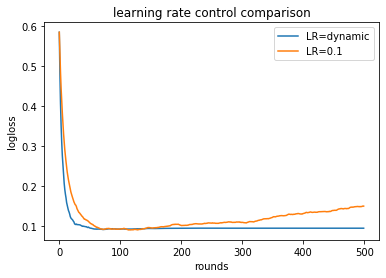

In [45]:
from sklearn.model_selection import StratifiedKFold

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)


param = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1" : 0.00010644546543696687,
    "lambda_l2" : 8.060164358035812e-08,
    "num_leaves" : 155,
    "feature_fraction" : 0.738197309672961,
    "bagging_fraction" : 0.8605153674117506,
    "bagging_freq" : 7,
    "min_child_samples" : 85,
}

# コールバックを用意する
lr_scheduler_cb = LrSchedulingCallback(strategy_func=sample_scheduler_func)
callbacks = [lr_scheduler_cb]

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)

# 動的に学習率を制御した場合
cv_results_d = lgb.cv(param, dtrain,
                        num_boost_round=500,
                        verbose_eval=0,
                        folds=skf, seed=42,
                        callbacks=callbacks,
                        )
dynamic_lr = cv_results_d['binary_logloss-mean']

# 学習率を 0.1 に固定した場合
param.update({'learning_rate': 0.1})
cv_results_s = lgb.cv(param, dtrain,
                    num_boost_round=500,
                    verbose_eval=0,
                    folds=skf, seed=42,
                    )
static_lr_0_1 = cv_results_s['binary_logloss-mean']

# グラフにプロットする
sns.lineplot(np.arange(len(dynamic_lr)),
             dynamic_lr,
             label='LR=dynamic')
sns.lineplot(np.arange(len(static_lr_0_1)),
             static_lr_0_1,
             label='LR=0.1')
plt.title('learning rate control comparison')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.legend()
plt.show()

コラム

hyperoptを使わずにベイズ最適化(optunaを使用)

- ライブラリに任せる
- 決定木の本数は多くしてアーリーストッピングを使う
- 学習率は0.1にしておく。提出時は小さくする。(トースターは変動派)
- チューニング時間を短縮するためCVは1foldのみ。実際に提出モデルを作成、検証、予測するときは異なる乱数の種で分割したfoldで行う。

| hyper paramater | base line | 探索範囲と事前分布 |
| ---- | ---- | ---- |
| learning rate | 0.1 | 固定 |
| number of iterations | 固定 | 大きな値をとりあえず入れる |
| maximum depth | 5 | 3~9、一様分布(1刻み) |
| Hessian regularization | 1.0 | 0.1~10.0 対数が一様分布になるように |
| Loss Regularization | 0.0 | 1e-8~ 1.0 対数が一様分布 |
| column sampling by tree | 0.8 | 0.60~0.95、一様分布 |
| row sampling | 0.8 | 0.60 ~ 0.95 一様分布 |
| L1 regularization | 0.0 | デフォルト値 |
| L2 regularization | 1.0 | デフォルト値 |



筆者のチューニング

1. ハイパーパラメータの初期値を設定する。
    - learning rate : 0.1 or 0.05
    - maximum depth : 決め打ち
    - column sampling by tree : 1.0
    - column sampling by level : 0.3(Percentage of columns used per split selection)
    - row sampling : 0.9
    - loss regularization : 0
    - Hessian regularization : 1
    - L1 regularization : 0
    - L2 regularization : 1
   
2. maximum depthの最適化
    - 5~8くらいを味見してから深くするか浅くする
    
3. column sampling by level
    - 0.1きざみで0.5~0.1

4. loss regularization
    - 1,2,4,8...

5. L1, L2
    - バランスを見て適当に

アーリーストッピングは10/学習率くらいにしている
    
    
Analytics Vidhyaの記事で紹介されている手動チューニング

1. ハイパーパラメータの初期値を設定する。
    - learning rate : 0.1
    - maximum depth : 5
    - column sampling by tree : 0.8
    - row sampling : 0.8
    - loss regularization : 0
    - Hessian regularization : 1
    - L1 regularization : 0
    - L2 regularization : 1
    
2. maximum depth, Hessian regularization
    - maximum depthを3～9まで2刻み、Hessian regularization を1～5まで1刻み

3. Loss Regularization 
    - 0.0~0.4ｍで
    
4. row sampling, column sampling by tree
    - 0.6~1.0まで0.1刻み
    
5. L1 regularization
    - 1e-5, 1e-2, 0.1, 1, 100

6. learning rateの減少

### 6.1.6 ニューラルネットのパラメータ及びそのチューニング

- ネットワークの構成 多層パーセプトロンが前提
    - 中間層の活性化関数　RELU、LeakyRELU、PRELU(これはLeakyReLUの改良版)
    - 中間層の数
    - 角層のユニット数、ドロップアウト率
    - Batch Normalization (BN)を入れるか

-　オプティマイザの選択
    - SGDとAdam
    - トースターの意見としては、多分SGDだと局所解に落ちるからモーメンタム入れるほうがいい気がする(更にやるならcosineアニーリング付きで)。Adamはだいたいいい感じになるが、押しに欠ける。RAdamとかAdamWの方が好き。
    - いずれにしても学習率は重要
    
- その他
    - バッチサイズ(ミニバッチ内のデータ数)
    - Weight Decayなどの正則化項の導入、オプティマイザの学習率以外のパラメータの調整
    
まず学習率を調整してある程度進むようなら他のパラメータ調整をすると良いと書かれている。

トースターの意見としては3～5層くらいのパーセプトロンでも学習進まないことがあるので、早期にBatch Normalizationすることをおすすめする。あとはDropout併用(5割くらい)するか若干(2割位)入れてみるか。

スコアの図があるので322ページ参照

コラム

多層パーセプトロンのチューニング例

| hyper paramater | base line | 探索範囲と事前分布 |
| ---- | ---- | ---- |
| 入力層のドロップアウト | 0.0 | 0.0～0.2、一様分布、0.05刻み |
| 中間層の数 | 3 | 2～4 1刻み |
| 中間層のユニット数 | 96 | 32～256 一様分布、32刻み |
| 中間層のドロップアウト | 0.2 | 0.0~0.3 一様分布、0.05刻み |
| Batch Normalization | 活性化関数の前 | もしくは設定しない |
| オプティマイザ | Adam | AdamもしくはSGD、学習率は1e-5～0.01、対数が一様分布 |
| バッチサイズ | 32 | 32～128、一様分布32刻み |
| エポック数 | 指定しない | アーリーストッピングを使う |


In [22]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

import optuna

DEVICE = torch.device("cuda:0")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    # We optimize the number of layers, hidden untis and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def get_mnist():
    # Load MNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the MNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    model.train()
    for epoch in range(EPOCHS):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(-1, 28 * 28).to(DEVICE), target.to(DEVICE)

            # Zeroing out gradient buffers.
            optimizer.zero_grad()
            # Performing a forward pass.
            output = model(data)
            # Computing negative Log Likelihood loss.
            loss = F.nll_loss(output, target)
            # Performing a backward pass.
            loss.backward()
            # Updating the weights.
            optimizer.step()

    # Validation of the model.
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Limiting validation data.
            if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                break
            data, target = data.view(-1, 28 * 28).to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability.
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / N_VALID_EXAMPLES
    return accuracy



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-04-29 15:25:21,508] Finished trial#0 with value: 0.925 with parameters: {'n_layers': 1, 'n_units_l0': 106, 'dropout_l0': 0.46906359740965725, 'optimizer': 'RMSprop', 'lr': 0.001080683809572086}. Best is trial#0 with value: 0.925.
[I 2020-04-29 15:25:27,927] Finished trial#1 with value: 0.9078125 with parameters: {'n_layers': 2, 'n_units_l0': 29, 'dropout_l0': 0.3335785549383267, 'n_units_l1': 49, 'dropout_l1': 0.4908082355006125, 'optimizer': 'Adam', 'lr': 0.007516669504675806}. Best is trial#0 with value: 0.925.
[I 2020-04-29 15:25:33,555] Finished trial#2 with value: 0.8984375 with parameters: {'n_layers': 1, 'n_units_l0': 62, 'dropout_l0': 0.2071881644382113, 'optimizer': 'SGD', 'lr': 0.08289574223936326}. Best is trial#0 with value: 0.925.
[I 2020-04-29 15:25:39,864] Finished trial#3 with value: 0.49921875 with parameters: {'n_layers': 2, 'n_units_l0': 126, 'dropout_l0': 0.2540609247212493, 'n_units_l1': 93, 'dropout_l1': 0.2101883159540476, 'optimizer': 'RMSprop', 'lr': 0.

Number of finished trials:  100
Best trial:
  Value:  0.9625
  Params: 
    n_layers: 2
    n_units_l0: 97
    dropout_l0: 0.2581206350138599
    n_units_l1: 87
    dropout_l1: 0.2743710041364531
    optimizer: Adam
    lr: 0.005974174176366611


### 6.1.7 線形モデルのパラメータ及びチューニング

ハイパーパラメータ少ない、計算速いので10倍刻みで調べると良い

scikit-learnのlinear_modelモジュールの各モデルの紹介

- Lasso, Ridge：alphaが正則化の強さを表す。LassoではL1正則化(係数の大きさに比例して罰則を与える)、RidgeではL2正則化(係数の大きさの2乗に比例して罰則を与える)
- ElasticNet :LassoとRidgeの半々みたいなモデル。alphaが生息家の強さを表すハイパーパラメータ。l1_ratioがL1とL2正則化の割合を表すパラメータ。
- LogisticRegression： Cが生息家の強さの逆数を表すパラメータ

## 6.2 特徴選択及び特徴量の重要度

与えられたデータの特徴量やそれから作成した特徴量にはモデルの精度に寄与しないばかりか悪化させる場合もある。有用な特徴量を撮ってくるのが大事。

特徴選択の方法

- 単変量統計を用いる方法
    - 相関係数やカイ2乗などの統計量から求める
- 特徴量の重要度を用いる方法
    - 主にGBDTやランダムフォレストなどの決定木モデルで、モデルから出力される特徴量の重要度から求める方法。単純に重要度の上位を選択するだけでなく、工夫した手法も存在する。
- 反復して探索する方法
    - 特徴量の組を変えてモデルをを学習させることを繰り返し、その精度などを用いて探索する手法
    
理論的な手法の他に試行や直感に基づいて試行錯誤するのも有効な場合がある旨が書かれている。

著者の意見

分析コンペにおいては特徴量がそれぞれ多少なり予測に役立つ情報を持っていること。GBDTでは意味のない特徴量があっても精度が落ちづらいこと、アンサンブルで過剰適合が抑えられることからそれほど特徴選択が行われていないように感じる。与えられたものは全て使い、考えて作った特徴量はスコア見ながら取捨選択するというのが一つのやりかた。
一方で機械的な作成から大量に特徴量を生成する手法もある。このときは計算コストが高いので特徴選択が重要。

特徴選択を行う場合にはGBDTの特徴量の重要度をベースとする手法が比較的よく使われていると思う。重要度をそのまま使う、重要度のCVのfold間での変動係数が小さい順に採用するなど。ランダムな値からなる特徴量と比較して重要かどうかを判別できる手法も用いると良いでしょう。（この文どういう意味かわからんかった）

トースターの意見

- GBDTはたしかに無駄な特徴入れても精度はほぼ落ちない。
- 過剰適合はめっちゃするので気をつけたほうがいい。ハイパーパラメータのチューニングでどうにかなるならいいんだけど。


### 6.2.1 単変量統計を用いる場合

各特徴量と目的変数からの何らかの統計量を計算し、その統計量の順序で特徴量選択する。単変量統計はあくまで特徴量と目的変数の1対1の関係を見るので特徴量の相互作用は考慮されない。

- 相関係数

いわゆる相関係数、線形の関係を前提とする。

要素xと目的変数yの組がある。

$(x_1, y_1), (x_2, y_2), ...(x_n, y_n)$とn対のデータが有る。$x_{\mu}$は$ \boldsymbol{x} $の平均、$y_{\mu}$は$ \boldsymbol{y} $の平均 ←ここ教科書誤植だよね。

$$
\rho = \frac{\sum_i(x_i-x_{\mu})(y_i-y_{\mu})}{\sqrt{\sum_i(x_i-x_{\mu})^2 \sum_i(y_i-y_{\mu})^2}}
$$

値の線形の関係性よりも値の大きさの順序関係のみに着目したい場合にはスピアマンの順位相関係数を使う。

相関係数はnumpyのcorrcoef関数、pandasのcorr関数、スピアマンの順位相関係数はscipy.statsモジュールのspearmanr関数を使うと便利

特徴選択はnumpyのargsort関数を使って自分で記述したほうが汎用性がある。


In [5]:
#indormation
import numpy as np

ary = np.array([10, 20, 30, 0])
idx = ary.argsort()
idx, idx[::-1]

(array([3, 0, 1, 2], dtype=int64), array([2, 1, 0, 3], dtype=int64))

In [6]:
#大きい方から3つ出力
ary[idx[::-1][:3]]

array([30, 20, 10])

In [7]:
# 相関係数
#pandas.DataFrame持ちっぽい

import scipy.stats as st

corrs = []
for c in train_x.columns:
    corr = np.corrcoef(train_x[c], train_y)[0, 1]
    corrs.append(corr)
corrs = np.array(corrs)

# スピアマンの順位相関係数
corrs_sp = []
for c in train_x.columns:
    corr_sp = st.spearmanr(train_x[c], train_y).correlation
    corrs_sp.append(corr_sp)
corrs_sp = np.array(corrs_sp)

# 重要度の上位を出力する（上位5個まで）
# np.argsortを使うことで、値の順序のとおりに並べたインデックスを取得できる
idx = np.argsort(np.abs(corrs))[::-1]
top_cols, top_importances = train_x.columns.values[idx][:5], corrs[idx][:5]
print(top_cols, top_importances)

idx2 = np.argsort(np.abs(corrs_sp))[::-1]
top_cols2, top_importances2 = train_x.columns.values[idx][:5], corrs_sp[idx][:5]
print(top_cols2, top_importances2)

- カイ2乗統計量

カイ2乗検定の統計量を計算し、統計量の大きい方から特徴量を選択する方法。この手法を用いるとき特徴量は非負での値、分類タスクである必要がある。特徴量の値のスケールに影響されるため、MinMaxScalerを使用すると良い。

scikit-learnのfeature_selectionモジュールのchi2関数を使用する。

- information

上記chi2関数の動き

1. 目的変数の各クラスごとにグルーピングして、特徴量の値の合計を観測度数とし、レコードの割合を期待確率とする集計表を作成する。（すでにわからない
2. その集計表に対し、観測度数が期待確率に基づいてランダムに抽出されたものかどうかのカイ2乗統計量を計算する。

特徴量の値が2値や頻度でない場合にそれを観測度数とすることは理論的に解釈しづらいが、それでも特徴量の値とクラスの関係性を見ることが可能らしい。

In [ ]:
# ---------------------------------
# カイ二乗統計量
# ---------------------------------
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# カイ二乗統計量
x = MinMaxScaler().fit_transform(train_x)
c2, _ = chi2(x, train_y)

# 重要度の上位を出力する（上位5個まで）
idx = np.argsort(c2)[::-1]
top_cols, top_importances = train_x.columns.values[idx][:5], corrs[idx][:5]
print(top_cols, top_importances)

- 相互情報量

各特徴量と目的変数との相互情報量を計算し、大きい方から選択する方法。確率変数XとYの相互情報量は以下の式

$$
I(X;Y) = \int_Y \int_X p(x,y) \log \frac{p(x,y)}{p(x)p(y)}dxdy
$$

相互情報量は、片方を知ることでもう片方をより推測できるようになる場合値が大きくなる。XとYが完全に従属のときはどちらかの変数の情報量と等しくなり、独立のときは0になる。

scikit-learnのfeature_selectionモジュールから、目的変数が連続変数の場合はmutual_info_regression関数、目的変数がクラス（分類タスク）のときはmutual_info_classif関数を使用する。

In [ ]:
# ---------------------------------
# 相互情報量
# ---------------------------------
from sklearn.feature_selection import mutual_info_classif

# 相互情報量
mi = mutual_info_classif(train_x, train_y)

# 重要度の上位を出力する（上位5個まで）
idx = np.argsort(mi)[::-1]
top_cols, top_importances = train_x.columns.values[idx][:5], corrs[idx][:5]
print(top_cols, top_importances)

著者の意見

学習データ全体で特徴選択してはいけない旨が書かれている。特徴選択もout-of-foldでやるべき。（当たり前では…？

### 6.2.2 特徴量の重要度を用いる方法

- ランダムフォレストの特徴量の重要度

ランダムフォレストは特徴量の重要度を出力できる。scikit-learnのRandomForestRegressor, RandomForestClassifierでは重要度は分岐を作成するときの基準となる値（回帰では2乗誤差、分類ではジニ不純度）の減少によって計算される。オプションで変えられたはず。

重要度の上位から特徴量を選択することで特徴選択を行える。

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレスト
clf = RandomForestClassifier(n_estimators=10, random_state=71)
clf.fit(train_x, train_y)
fi = clf.feature_importances_

# 重要度の上位を出力する
idx = np.argsort(fi)[::-1]
top_cols, top_importances = train_x.columns.values[idx][:5], fi[idx][:5]
print('random forest importance')
print(top_cols, top_importances)

- GBDTの特徴量の重要度

LightGBMで説明する。標準はゲインになってるはず。


In [8]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)

param = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1": 1e-8,
    "lambda_l2": 1e-8,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 1.0,
    "bagging_freq": 1,
    "min_child_samples": 5,
}

gbm = lgb.train(param, dtrain)
preds = gbm.predict(test_x)
pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
print(accuracy)

0.9370629370629371


In [17]:
import pandas as pd
f_importance = pd.DataFrame({'feature': range(len(gbm.feature_importance())), 'importance':gbm.feature_importance()}).sort_values('importance', ascending=False)

f_importance

,feature,importance
27,27,197
7,7,166
21,21,127
1,1,127
14,14,108
13,13,106
22,22,100
28,28,100
19,19,90
12,12,82


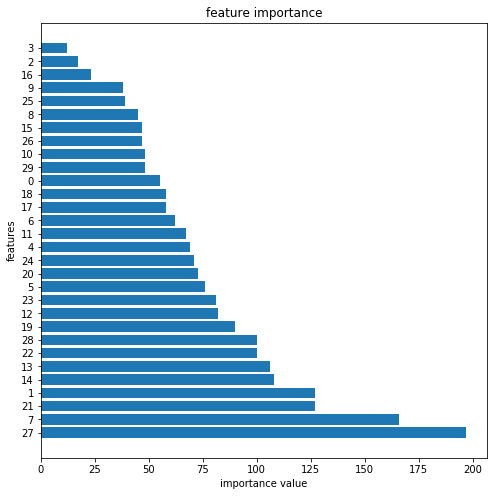

In [19]:
import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(8,8))
plt.barh(np.array(range(f_importance.shape[0])),
        np.array(f_importance.importance.T),
        tick_label=list(f_importance.feature))
plt.title("feature importance")
plt.xlabel("importance value")
plt.ylabel("features")
plt.show()

- permutation importance

モデルを学習させたあとに、通常どおりに予測させたときのバリデーションデータのスコアと、ある特徴量の列をシャッフルして予測させたときのバリデーションデータのスコアを比較してシャッフルしたときどの程度予測精度が落ちるかということからその特徴量の重要度を計算する手法。
モデルの種類に関わらず適用可能な点が大きい。

eli5がおすすめされているがscikit-learn内に収まるなら0.22からpermutation importanceはかるモジュールが入ってるのでそちらがおすすめ。

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)

RFC = RandomForestClassifier(criterion = 'entropy')
RFC.fit(train_x, train_y)

result = permutation_importance(RFC, test_x, test_y, scoring='neg_log_loss', n_repeats=30, random_state=3, n_jobs=8)

In [26]:
p_importance = pd.DataFrame({'feature': range(len(result.importances_mean)), 'importance':result.importances_mean}).sort_values('importance', ascending=True)
p_importance

,feature,importance
12,12,-0.138662
26,26,-0.124339
27,27,-0.097871
6,6,-0.095837
20,20,-0.091947
2,2,-0.085530
0,0,-0.081957
7,7,-0.077771
23,23,-0.077655
3,3,-0.073312


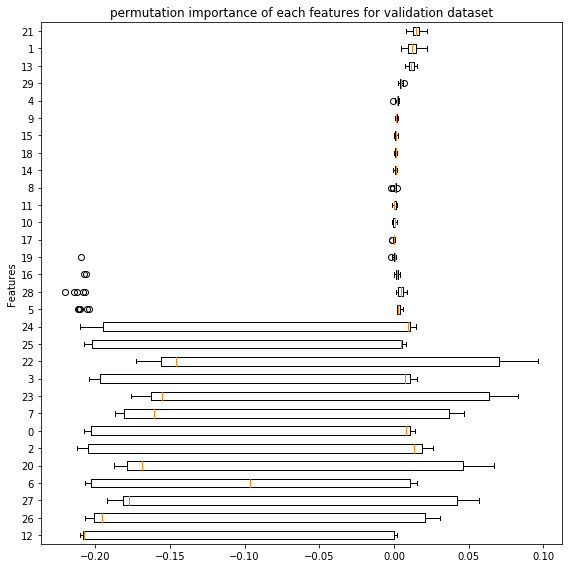

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T,
          vert=False, labels=p_importance.feature)
ax.set_title("permutation importance of each features for validation dataset")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

- null importance

目的変数をシャッフルして学習させたときの重要度をnull importanceとして基準として、目的変数をシャッフルしていない通常の重要度をactual importanceとしてこの違いを重要度とする。

両者ともに複数回行うのが普通のやり方。（並べ替え具合によってスコアが変わるので）

- boruta

上記2つとはまた違う方法でシャッフルして特徴選択を行う方法。それぞれの特徴量をシャッフルしたデータを作成し、これをshadow featureと呼ぶ。shadow featureを元のデータの列方向に加えてランダムフォレストで学習を行い特徴量の重要度計算する。このときそれぞれの特徴量の重要度がshadow featureのうち最も高い重要度よりも高いかどうかを判定して記録する。これを繰り返し行いshadow featureより重要と言えない特徴量を除外し残った特徴量によって再び学習を行い、十分に高い重要度を保つ特徴量を選別する。BorutaPyというライブラリが公開されている。

- 特徴量を大量生成してからの特徴選択

特徴量を考察及び機械的な組み合わせを数千～数万作り特徴選択する。

- xgbfir

xgboost使い用

- Greedy Forward Selection

1. 使用する特徴量の集合を空集合から始める（この集合をMとする）
2. 候補となる特徴量それぞれについてMに加えた場合のスコアを計算する。
3. 最もスコアを改善させた特徴量をMに加える
4. 3.で採用された特徴量を候補から外し、2と3をスコアの改善が止まるまで続ける

デメリットは計算コストがでかい。簡便版は以下

1. 使用する特徴量の集合を空集合から始める（この集合をMとする）
2. 候補となる特徴量を有望な順番もしくはランダムな順番に並べる。
3. 次の特徴量を加えることでスコアが良くなればMに加える、そうでなければ加えない。
4. 3.をすべての候補について繰り返す。

In [ ]:
# ---------------------------------
# Greedy Forward Selection
# ----------------------------------

best_score = 9999.0
selected = set([])

print('start greedy forward selection')

while True:

    if len(selected) == len(train_x.columns):
        # すべての特徴が選ばれて終了
        break

    scores = []
    for feature in train_x.columns:
        if feature not in selected:
            # 特徴量のリストに対して精度を評価するevaluate関数があるものとする
            fs = list(selected) + [feature]
            score = evaluate(fs)
            scores.append((feature, score))

    # スコアは低い方が良いとする
    b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
    if b_score < best_score:
        selected.add(b_feature)
        best_score = b_score
        print(f'selected:{b_feature}')
        print(f'score:{b_score}')
    else:
        # どの特徴を追加してもスコアが上がらないので終了
        break

print(f'selected features: {selected}')

# ---------------------------------
# Greedy Forward Selectionを単純化した手法
# ----------------------------------

best_score = 9999.0
candidates = np.random.RandomState(71).permutation(train_x.columns)
selected = set([])

print('start simple selection')
for feature in candidates:
    # 特徴量のリストに対して精度を評価するevaluate関数があるものとする
    fs = list(selected) + [feature]
    score = evaluate(fs)

    # スコアは低い方が良いとする
    if score < best_score:
        selected.add(feature)
        best_score = score
        print(f'selected:{feature}')
        print(f'score:{score}')

print(f'selected features: {selected}')


## 6.3クラスの分布が偏っている場合

- アンダーサンプリング

負例が多い場合に負例の一部のみを使用してモデルを作る。異なる負例を取り出して学習させた複数のモデルを平均する手法（バギング）も有効

    - 効率麺ではメリットが多い
    - 特徴量を作るときは負例のすべてのデータを使うほうがいい。
    - すべてのデータで学習した場合とバリデーションで精度比較し確認したほうがいい
    
- 特に工夫しない
- 重み付け
    -正例と負例のウェイト合計がおなじになるようにする。
- オーバーサンプリング
    - 負例のほうが多い場合に正例を増やしてモデルを学習させる方法。単純に増やすだけでなく、SMOTEなどの人工的に正例を生成する方法がある。
- 確率を予測する場合の注意点
    - loglossなど適切な確率予測をする必要がある場合は注意が必要。比率を変えたときは確率の補正が必要。
    - 筆者はGBDTまともだと言ってるが、GBDTも疑ったほうがいい。多層パーセプトロンでも深い場合は注意が必要。
    
コラム

ベイズ最適化とTPEのアルゴリズム